In [12]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
import cantera as ct

# Load your solver file
from Project_3_4 import solve_pfr_cantera, solve_pfr_pyrolysis

In [13]:
def cumtrapz_np(y, x):
    out = np.zeros_like(y)
    for i in range(1, len(y)):
        out[i] = out[i-1] + 0.5*(y[i] + y[i-1])*(x[i] - x[i-1])
    return out

def compute_residence_time(x, T, Y, p0, mechfile, mdot, D):
    gas = ct.Solution(mechfile)
    A = np.pi * D**2 / 4
    rho = np.zeros_like(x)
    u   = np.zeros_like(x)

    for j in range(len(x)):
        gas.TPY = T[j], p0, Y[:, j]
        rho[j] = gas.density
        u[j]   = mdot / (rho[j] * A)

    tau = cumtrapz_np(1/u, x)
    return tau

=== Verification 4.1 ===


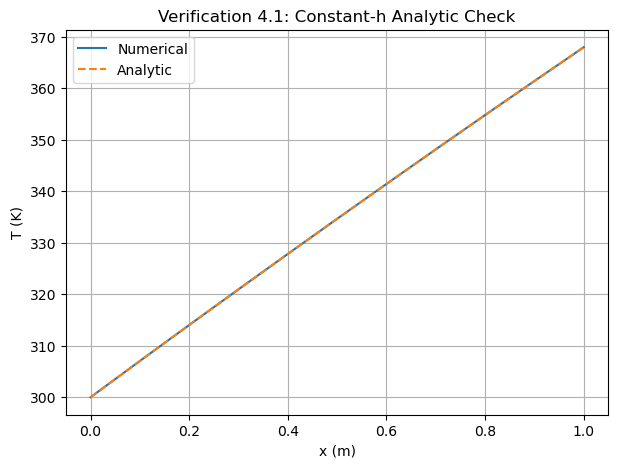

In [14]:
print("=== Verification 4.1 ===")

mech = "gri30.yaml"
T0 = 300.0
Tw = 1200.0
p0 = ct.one_atm
mdot = 0.1
D = 0.05
x_end = 1.0

h_val = 50.0
cp_val = 1000.0

def h_const(T, Y, p, rho, u): return h_val
def cp_const(T): return cp_val

sol = solve_pfr_cantera(
    mechfile=mech,
    X0={"N2":1},
    T0=T0,
    p0=p0,
    mdot=mdot,
    D=D,
    Tw=Tw,
    x_end=x_end,
    Npts=200,
    h_override=h_const,
    cp_override=cp_const
)

x = sol["x"]
T_num = sol["T"]

Per = np.pi*D
K = h_val * Per / (mdot*cp_val)
T_anal = Tw + (T0-Tw)*np.exp(-K*x)

plt.figure(figsize=(7,5))
plt.plot(x, T_num, label="Numerical")
plt.plot(x, T_anal, '--', label="Analytic")
plt.xlabel("x (m)"); plt.ylabel("T (K)")
plt.title("Verification 4.1: Constant-h Analytic Check")
plt.grid(); plt.legend()
plt.show()

=== Verification 4.2 ===


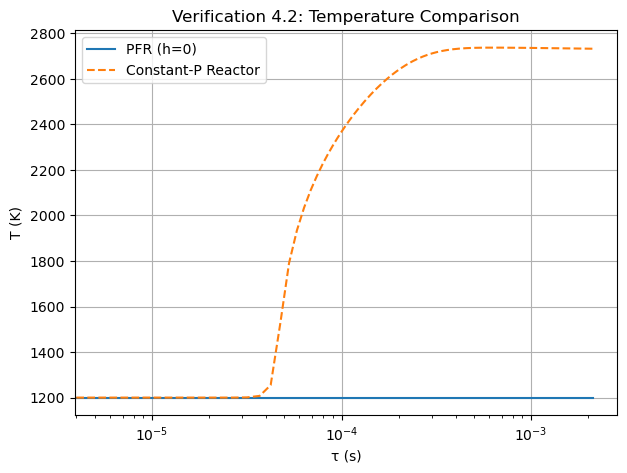

In [15]:
print("=== Verification 4.2 ===")

mech = "gri30.yaml"
X0 = "H2:2, O2:1, N2:4"
T0 = 1200
p0 = ct.one_atm

mdot = 0.1
D = 0.05
x_end = 0.5

def h_zero(T, Y, p, rho, u): return 0.0

sol = solve_pfr_cantera(
    mechfile=mech,
    X0=X0,
    T0=T0,
    p0=p0,
    mdot=mdot,
    D=D,
    Tw=T0,
    x_end=x_end,
    Npts=400,
    h_override=h_zero
)

x = sol["x"]
T_pfr = sol["T"]
Y_pfr = sol["Y"]

tau = compute_residence_time(x, T_pfr, Y_pfr, p0, mech, mdot, D)

# Cantera CP reactor
gas = ct.Solution(mech)
gas.TPX = T0, p0, X0
r = ct.IdealGasConstPressureReactor(gas)
sim = ct.ReactorNet([r])

T_batch = np.zeros_like(tau)
for j, t in enumerate(tau):
    sim.advance(t)
    T_batch[j] = r.T

plt.figure(figsize=(7,5))
plt.plot(tau, T_pfr, label="PFR (h=0)")
plt.plot(tau, T_batch, '--', label="Constant-P Reactor")
plt.xscale('log')
plt.xlabel("τ (s)"); plt.ylabel("T (K)")
plt.title("Verification 4.2: Temperature Comparison")
plt.grid(); plt.legend()
plt.show()

=== Verification 4.3 ===


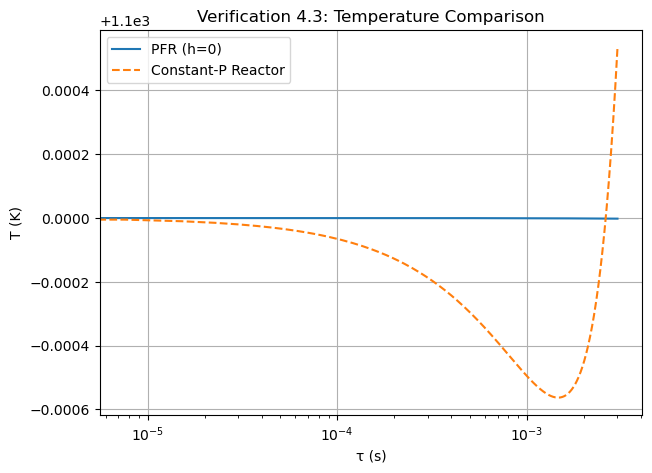

In [16]:
print("=== Verification 4.3 ===")

mech = "gri30.yaml"
X0 = "CH4:1, O2:2, N2:7.52"
T0 = 1100
p0 = ct.one_atm

mdot = 0.1
D = 0.05
x_end = 0.5

def h_zero(T, Y, p, rho, u): return 0.0

sol = solve_pfr_cantera(
    mechfile=mech,
    X0=X0,
    T0=T0,
    p0=p0,
    mdot=mdot,
    D=D,
    Tw=T0,
    x_end=x_end,
    Npts=400,
    h_override=h_zero
)

x = sol["x"]
T_pfr = sol["T"]
Y_pfr = sol["Y"]

tau = compute_residence_time(x, T_pfr, Y_pfr, p0, mech, mdot, D)

# Cantera CP reactor
gas = ct.Solution(mech)
gas.TPX = T0, p0, X0
r = ct.IdealGasConstPressureReactor(gas)
sim = ct.ReactorNet([r])

T_batch = np.zeros_like(tau)
for j, t in enumerate(tau):
    sim.advance(t)
    T_batch[j] = r.T

plt.figure(figsize=(7,5))
plt.plot(tau, T_pfr, label="PFR (h=0)")
plt.plot(tau, T_batch, '--', label="Constant-P Reactor")
plt.xscale('log')
plt.xlabel("τ (s)"); plt.ylabel("T (K)")
plt.title("Verification 4.3: Temperature Comparison")
plt.grid(); plt.legend()
plt.show()

In [17]:
print("=== Mechanism Comparison for CH4 Pyrolysis ===")

mechanisms = {
    "GRI-Mech 3.0": "gri30.yaml",
    "USC Mech II":  "USCII.yaml",
    "ABF Soot":     "abf.yaml",
    "Cai-Pitsch":   "cai_pisch.yaml"
}

D = 0.05
u0 = 1.0
T0 = 1200
Tw = 1500
p0 = ct.one_atm
x_end = 10.0

results = {}

for name, mech in mechanisms.items():
    print(" → Running:", name)
    try:
        sol = solve_pfr_pyrolysis(
            mechfile = mech,
            X0 = {"CH4":1.0},
            T0 = T0,
            p0 = p0,
            u0 = u0,
            D = D,
            Tw = Tw,
            x_end = x_end,
            Npts = 400
        )
        results[name] = sol
        print("   ✓ Success")
    except Exception as e:
        print("   ✗ Failed:", e)

=== Mechanism Comparison for CH4 Pyrolysis ===
 → Running: GRI-Mech 3.0
   ✓ Success
 → Running: USC Mech II
   ✓ Success
 → Running: ABF Soot
   ✓ Success
 → Running: Cai-Pitsch
   ✓ Success


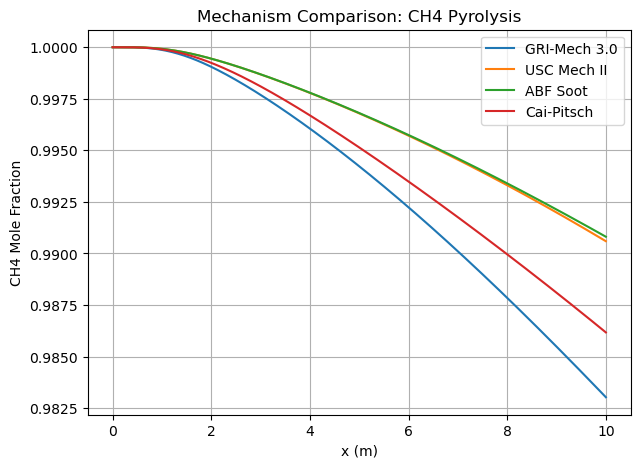

In [9]:
plt.figure(figsize=(7,5))
for name, sol in results.items():
    gas = sol["gas"]; X = sol["X"]
    idx = gas.species_index("CH4")
    plt.plot(sol["x"], X[idx], label=name)

plt.xlabel("x (m)"); plt.ylabel("CH4 Mole Fraction")
plt.title("Mechanism Comparison: CH4 Pyrolysis")
plt.grid(); plt.legend()
plt.show()